# Notebook to explore PCA of data of light and intrinsic data set 

The idea is to compare this to Rikhav's cut based analysis. 

In [50]:
import numpy as np
import glob
import os
import tqdm
import itertools
import matplotlib.pyplot as plt
import time
import copy
from fastespy.readpydata import convert_data_to_ML_format
from fastespy.plotting import plot_2d_hist, plot_scatter_w_hist
from fastespy.ml import MLHyperParTuning
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [4]:
%matplotlib inline

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

### Explore the data

Let's take a look at the data from Rikhav's intrinsic runs, done at $R_N = 0.3$ and a gain width product of 1.5 GHz. The trigger threshold was set to 20mV.

In [7]:
path = "../../../data-01152021/"
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
print(files[0])

17
../../../data-01152021/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy


In [8]:
for f in files:
    print(os.path.basename(f))

0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-3-fit000.npy
0.3RN-1.5GHz-light-000-fit.npy
0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-9-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-13-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-14-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-1-fit000.npy
0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-6-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-11-fit000.npy
0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-8-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-12-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hr-2-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-17-fit000.npy
0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-7-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-10-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-15-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-18-fit000.npy


In [9]:
x = np.load(files[0], allow_pickle=True).tolist()
print(len(x.keys()))  # number of recorded triggers
#print(x.keys())  # in Rikhav's files, the keys are integers from 1,..., N_trigger 
x[1]

1709


{'start time in hrs': 0.01628305595,
 'end time in hrs': 0.0162831115,
 'data': array([-0.0012398 , -0.00112535, -0.00089647, ...,  0.00028611,
        -0.00024796,  0.00020981]),
 'time': array([58.61900142, 58.61900144, 58.61900146, ..., 58.61920136,
        58.61920138, 58.6192014 ]),
 'rise time': 1.7650903275199694e-06,
 'rise time error': 1.5309936511128432e-08,
 'decay time': 2.287605898160283e-05,
 'decay time error': 2.5212876321734424e-07,
 'constant': 0.0004085272957005441,
 'constant error': 3.960175446925966e-05,
 'amplitude': 0.01804428397975213,
 'amplitude error': 7.416273727863304e-05,
 'pulse integral raw': -7.72645215374739e-07,
 'pulse integral raw error': 3.000000248221113e-07,
 'pulse height': -0.031212677749656446,
 'pulse height error': 0.0014603982455307404,
 'trigger time': 2.966826527028843e-05,
 'chi2 reduced': 1.7620628040853559,
 'voltage error': 0.0015,
 'pulse integral fit': -8.3209149181234e-07}

Define the key words that you would like to save

In [10]:
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
         ]

for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

print(feature_names)

['rise time', 'decay time', 'constant', 'amplitude', 'pulse height', 'chi2 reduced', 'pulse integral fit']


In [11]:
light_cleaning_cuts = {
    "chi2 reduced": "chi2 < 6.",
    "decay time" : "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)", # from gaussian fit, 5 sigma interval 
}

In [12]:
result = {'type': []}
t_tot_hrs = 0.

id_rejected = []

data = {"time": [], "data": []}
# loop through files
for f in tqdm.tqdm(files): 
    x = np.load(f, allow_pickle=True).tolist()

    # for each file: calculate observation time
    t_start = 1e10
    t_stop = 0.
    
    if 'light' in f:
        print(len(x))
        id_rejected.append([])
    
    # loop through triggers
    for i in range(1,len(x.keys())+1):
                # light sample cleaning
        if 'light' in f:
            m = True
            for c, v in light_cleaning_cuts.items():
                #print(i, v, {c.split()[0]: x[i][c]})
                m &= eval(v, {c.split()[0]: x[i][c]})   
            
            if not m:
                id_rejected[-1].append(i)
                continue

        for name in feature_names:
            if not name in result.keys():
                result[name] = []
                
            result[name].append(x[i][name])
            
        # save raw data
        data['time'].append(x[i]['time'])
        data['data'].append(x[i]['data'])
        
        if 'intrinsic' in f:
            if x[i]['end time in hrs'] > t_stop:
                t_stop = x[i]['end time in hrs']
            if x[i]['start time in hrs'] < t_start:
                t_start = x[i]['start time in hrs']
            result['type'].append(0)
        
        if 'light' in f:
            result['type'].append(1)

    if 'intrinsic' in f:
        t_tot_hrs += t_stop - t_start  # only add for dark count rate


        
for k in ['time', 'data']:
    data[k] = np.array(data[k])
    
# convert into into numpy arrays
for k, v in result.items():
    if k == 'type':
        dtype = np.bool
    else:
        dtype = np.float32
    result[k] = np.array(v, dtype=dtype)

 18%|█▊        | 3/17 [00:02<00:08,  1.69it/s]

2627


100%|██████████| 17/17 [00:10<00:00,  1.69it/s]


In [13]:
len(id_rejected)

1

In [14]:
for rej in id_rejected:
    print("Rejected {0:n} triggers in light file".format(len(rej)))

Rejected 1561 triggers in light file


# Apply PCA

Apply PCA to see which features are the most important

In [15]:
feature_names

['rise time',
 'decay time',
 'constant',
 'amplitude',
 'pulse height',
 'chi2 reduced',
 'pulse integral fit']

### Run it for all features

In [120]:
def run_pca_analysis(feature_names, figsize=(6,4), log_all=True,
                     negative_features = ['pulse height', 'pulse integral fit'], elev=20., azim=30.):
    X, y = convert_data_to_ML_format(result,
                                 feature_names,
                                 bkg_type=0,
                                 signal_type=1)
    
    m = np.ones(X.shape[0], dtype=np.bool)
    if log_all:
        for i, fn in enumerate(feature_names):
            if fn == 'constant':
                X[:, i] += 1.
                
            #m &= np.abs(X[:, i]) > 0
            if fn in negative_features:
                X[m, i] = np.log10(-X[m, i])
            else:
                X[m, i] = np.log10(X[m, i])
    
            m &= np.isfinite(X[:, i])
    #if "pulse integral fit" in feature_names:
    #    log_idx = feature_names.index("pulse integral fit")
    #    m = np.abs(X[:, log_idx]) > 0
    #    X[m, log_idx] = np.log10(-1. * X[m, log_idx])
    #else:
    #    m = np.ones(X.shape[0], dtype=np.bool)
    
    print(np.sum(m), m.shape)
    pca = PCA(n_components=2)
    pca_3d = PCA(n_components=3)
    pca_all = PCA(n_components=None)
    
    pca.fit(X[m])
    pca_3d.fit(X[m])
    pca_all.fit(X[m])
    
    X_trans = pca.transform(X[m])
    X_trans_3d = pca_3d.transform(X[m])
    
    plt.figure(1, figsize=figsize, dpi=150)
    m_sig = y[m] == 1
    plt.scatter(X_trans[~m_sig,0], X_trans[~m_sig,1], marker='.', alpha=0.5, label='bkg')
    plt.scatter(X_trans[m_sig,0], X_trans[m_sig,1], marker='.', alpha=0.5, label='signal')
    plt.legend()
    plt.grid()
    plt.xlabel("Component 1", fontsize='x-large')
    plt.ylabel("Component 2", fontsize='x-large')
    
    
    plt.figure(2, figsize=figsize, dpi=150)
    for i, c in enumerate(pca_all.components_):
        plt.plot(c,
             marker='o',
             color=plt.cm.Blues_r(i / float(len(pca_all.components_))),
             label="Comp. {1:n}, exp. var.: {0:.2e}".format(pca_all.explained_variance_ratio_[i], i+1))
    plt.legend(ncol=3, fontsize='x-small')
    _ = plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize='x-large')
    plt.grid()
    
    
    plt.figure(3, figsize=figsize, dpi=150)
    for i, c in enumerate(pca.components_):
        plt.plot(c,
             marker='o',
             color=plt.cm.Blues_r(i / float(len(pca.components_))),
             label="Comp. {1:n}, exp. var.: {0:.2e}".format(pca_all.explained_variance_ratio_[i], i+1))
    plt.legend(ncol=3, fontsize='x-small')
    _ = plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize='x-large')
    plt.grid()
    
    plt.figure(4, figsize=figsize, dpi=150)
    for i, c in enumerate(pca_3d.components_):
        plt.plot(c,
             marker='o',
             color=plt.cm.Blues_r(i / float(len(pca.components_))),
             label="Comp. {1:n}, exp. var.: {0:.2e}".format(pca_all.explained_variance_ratio_[i], i+1))
    plt.legend(ncol=3, fontsize='x-small')
    _ = plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, fontsize='x-large')
    plt.grid()
    
    fig = plt.figure(5, figsize=figsize, dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(X_trans_3d[~m_sig, 0], X_trans_3d[~m_sig, 1], X_trans_3d[~m_sig, 2], ls="None", marker='.', color="C0", label='bkg', alpha=0.3, ms=1)
    ax.plot(X_trans_3d[m_sig, 0], X_trans_3d[m_sig, 1], X_trans_3d[m_sig, 2], ls="None",  marker='.', color="C1", label='signal', alpha=0.3, ms=1)
    ax.set_xlabel("Component 1")
    ax.set_xlim(-3, 3)
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")

    ax.grid()
    ax.legend()
    ax.view_init(elev=elev, azim=azim)

/Users/manuelmeyer/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


40412 (40646,)


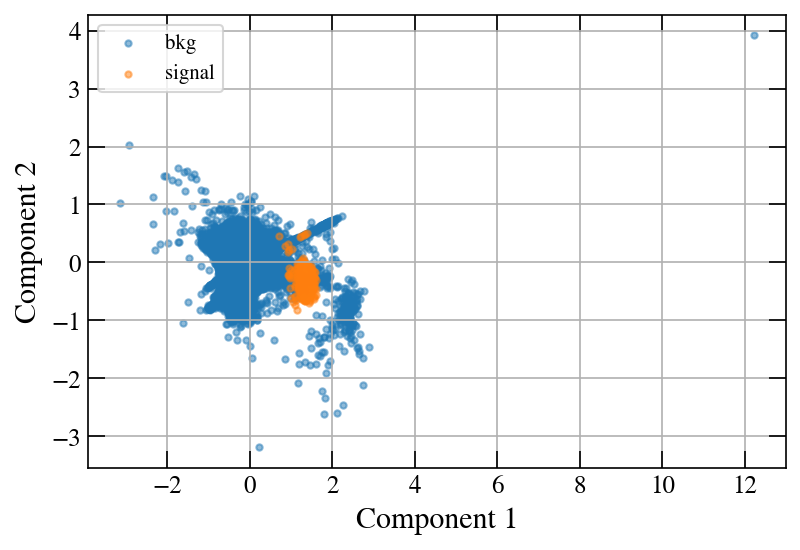

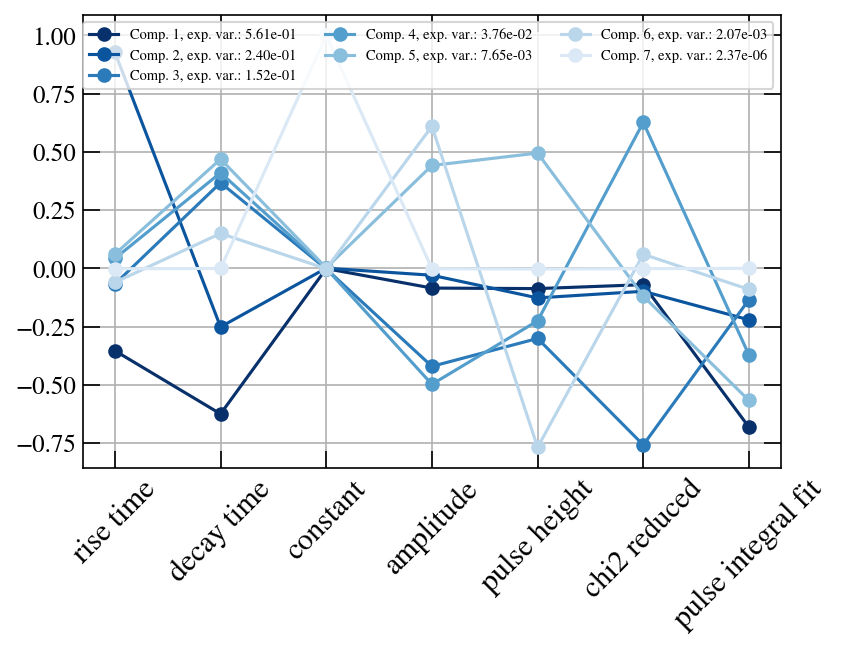

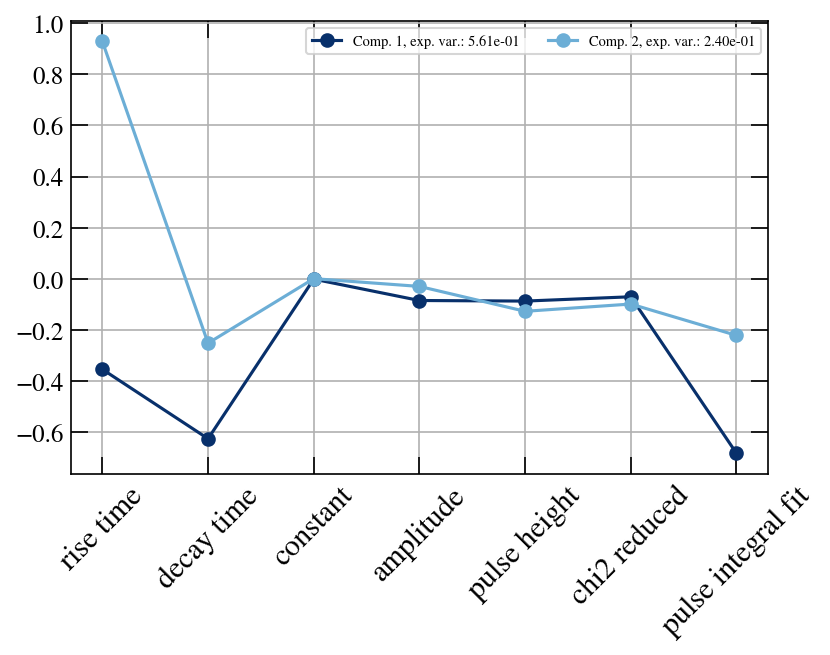

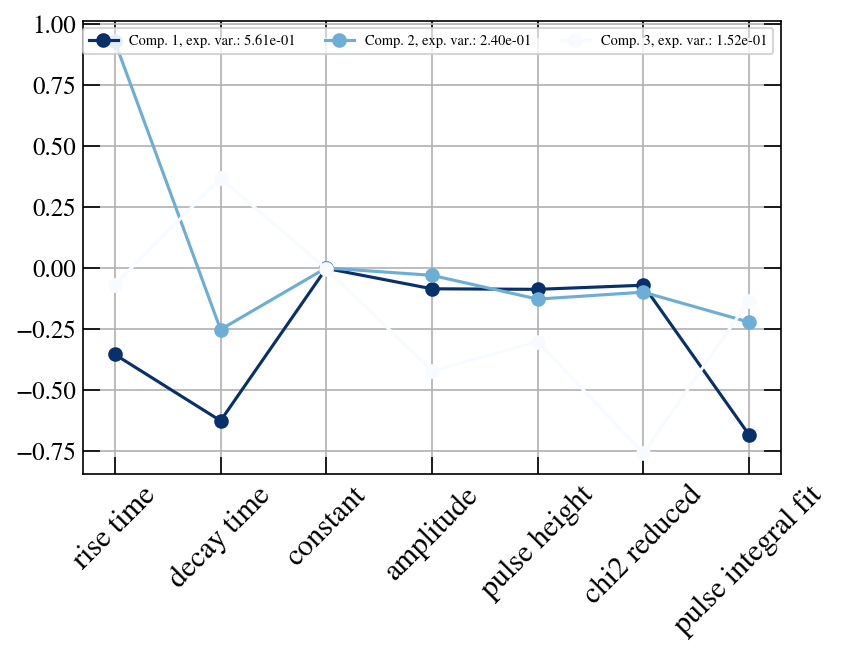

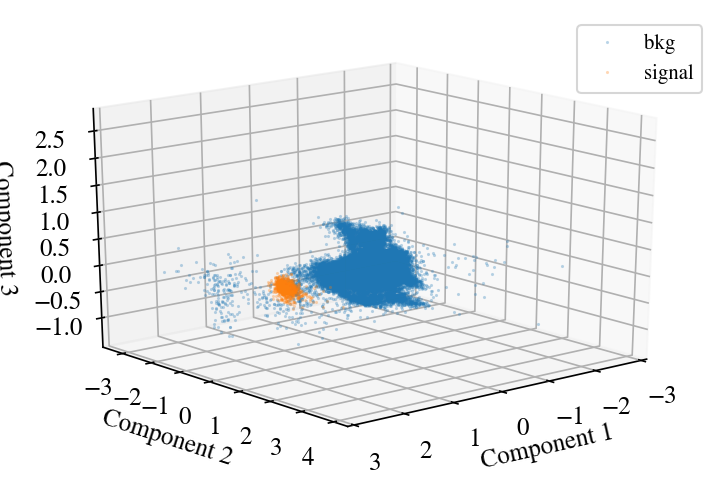

In [121]:
run_pca_analysis(feature_names, elev=20., azim=50.)

In [92]:
feature_names_reduced = [
    'rise time',
     'decay time',
#     'constant',
#     'amplitude',
     'pulse height',
#    'chi2 reduced',
     'pulse integral fit'  
]

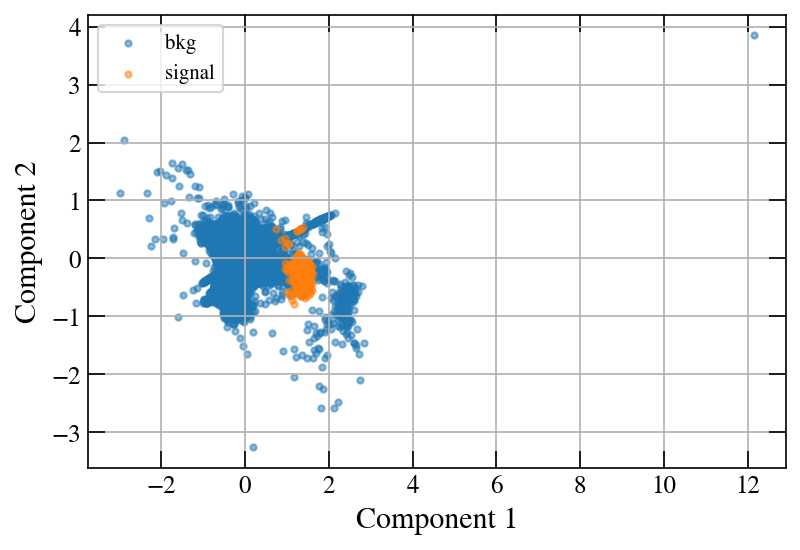

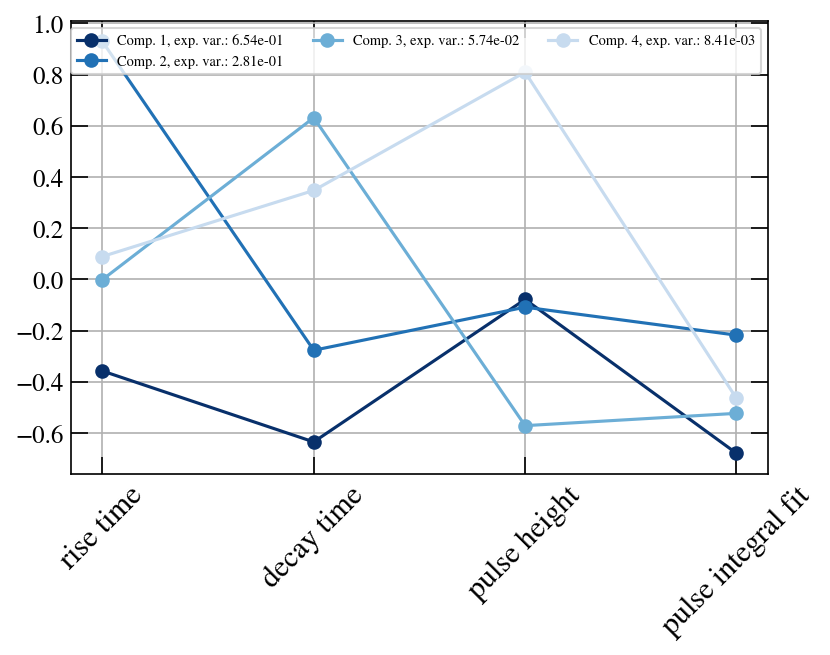

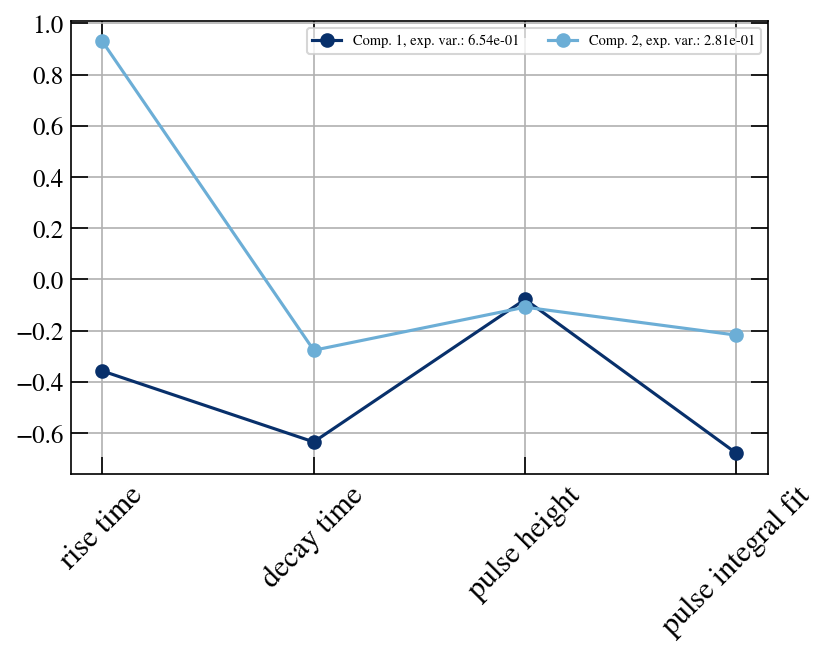

In [47]:
run_pca_analysis(feature_names_reduced)